In [4]:
from keras.layers import Input, Dense
from keras import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from math import sqrt
from sklearn.metrics import mean_squared_error

In [6]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train (1).csv


In [7]:
train = pd.read_csv("/content/train.csv")

In [8]:
test = pd.read_csv("/content/test.csv")

In [9]:
target = train.SalePrice
train.drop(['SalePrice'],axis = 1 , inplace = True)


train = train.append(test)

In [10]:
# getting test datatypes
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

In [11]:
train.drop(['Id'], inplace = True, axis = 1)

In [12]:
def get_cols_with_no_nans(df, col_type):
   
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    return [col for col in predictors.columns if not df[col].isnull().any()]
    

num_cols = get_cols_with_no_nans(train , 'num')
cat_cols = get_cols_with_no_nans(train , 'no_num')


num_cols_test = get_cols_with_no_nans(test , 'num')
cat_cols_test = get_cols_with_no_nans(test , 'no_num')

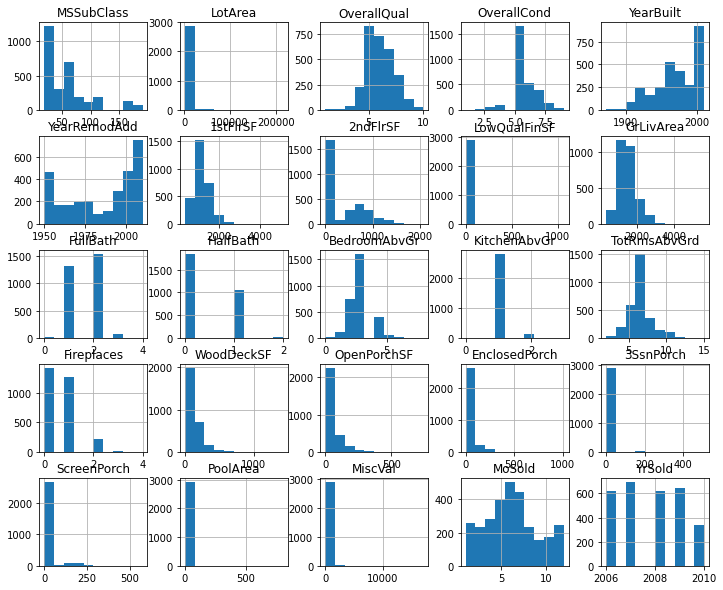

In [13]:
train = train[num_cols + cat_cols]
train.hist(figsize = (12,10))
plt.show()

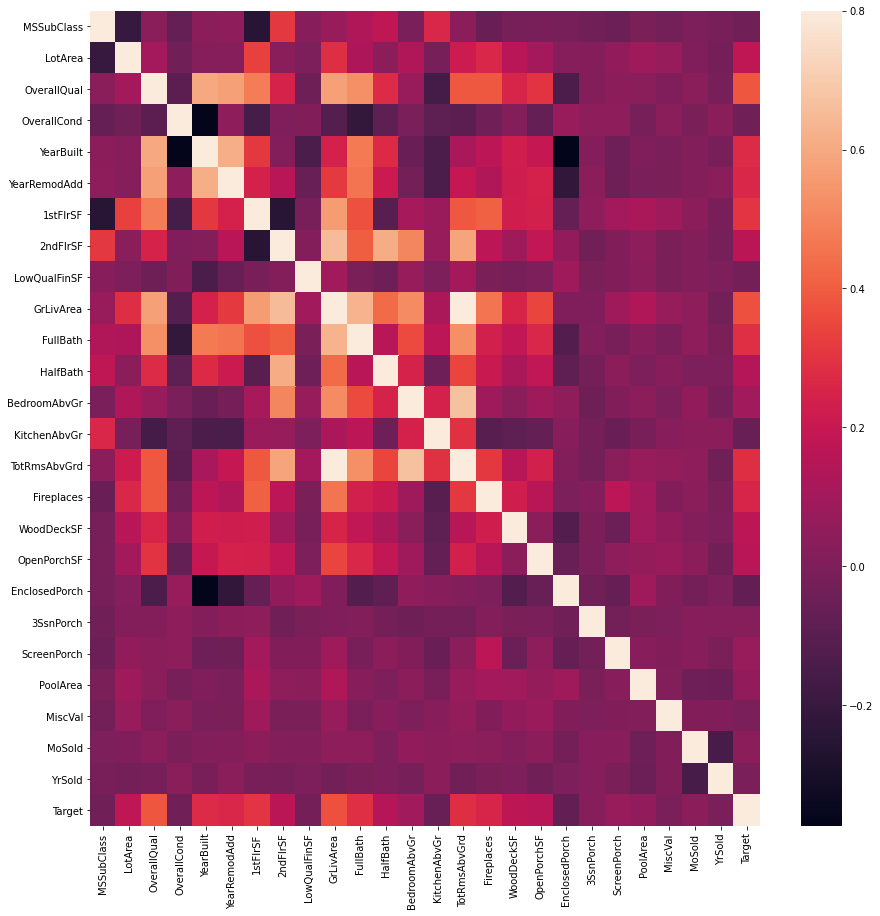

In [14]:
train = train[num_cols + cat_cols]
train['Target'] = target

Corr = train.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(Corr, vmax = 0.8)
plt.show()

In [15]:
def oneHotEncode(df, colNames):
    for col in colNames:
        if df[col].dtype == np.dtype('object'):
            df = pd.concat([df, pd.get_dummies(df[col], prefix = col)], axis = 1)

            # dropping encoded col
            df.drop([col], axis = 1 , inplace = True)
    return df

train = oneHotEncode(train, cat_cols)

train.dtypes

MSSubClass               int64
LotArea                  int64
OverallQual              int64
OverallCond              int64
YearBuilt                int64
                         ...  
SaleCondition_AdjLand    uint8
SaleCondition_Alloca     uint8
SaleCondition_Family     uint8
SaleCondition_Normal     uint8
SaleCondition_Partial    uint8
Length: 150, dtype: object

In [16]:
def split_combined():
    global train
    return (train[:1460] , train[1460:]) 
  
train, test = split_combined()

In [17]:
from keras import Sequential 
NN_model = Sequential() 

# i/p layer 
NN_model.add(Dense(128, kernel_initializer = 'normal', input_dim = train.shape[1], activation = 'relu')) 

# hideen layers
NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu')) 
NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu')) 
NN_model.add(Dense(256, kernel_initializer = 'normal', activation = 'relu')) 

# o/p layer
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear')) 

# compiling
NN_model.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['mean_absolute_error']) 
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               19328     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 184,193
Trainable params: 184,193
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.callbacks import ModelCheckpoint 

# Define a checkpoint to save the data 
checkpoint_name = '/content/Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode ='auto') 
callbacks_list = [checkpoint] 

# Train the model
hist=NN_model.fit(train, target, epochs = 300, batch_size = 32, validation_split = 0.2, callbacks = callbacks_list) 

Epoch 1/300
37/37 [==============================] - 1s 14ms/step - loss: 119715.6542 - mean_absolute_error: 119715.6542 - val_loss: 8134.4512 - val_mean_absolute_error: 8134.4512

Epoch 00001: val_loss improved from inf to 8134.45117, saving model to /content/Weights-001--8134.45117.hdf5
Epoch 2/300
37/37 [==============================] - 0s 5ms/step - loss: 5482.4178 - mean_absolute_error: 5482.4178 - val_loss: 3247.3916 - val_mean_absolute_error: 3247.3916

Epoch 00002: val_loss improved from 8134.45117 to 3247.39160, saving model to /content/Weights-002--3247.39160.hdf5
Epoch 3/300
37/37 [==============================] - 0s 5ms/step - loss: 3013.8162 - mean_absolute_error: 3013.8162 - val_loss: 5239.5771 - val_mean_absolute_error: 5239.5771

Epoch 00003: val_loss did not improve from 3247.39160
Epoch 4/300
37/37 [==============================] - 0s 5ms/step - loss: 3898.2434 - mean_absolute_error: 3898.2434 - val_loss: 3609.6035 - val_mean_absolute_error: 3609.6035

Epoch 00004:

In [27]:
# Load weights file of the best model : 
weights_file = '/content/Weights-173--49.83088.hdf5' 
# choose the best checkpoint 
NN_model.load_weights(weights_file) 
# load it 
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [28]:
predictions = NN_model.predict(test)
predictions

array([[208478.58],
       [180281.48],
       [223438.84],
       ...,
       [209984.66],
       [266407.44],
       [142090.86]], dtype=float32)

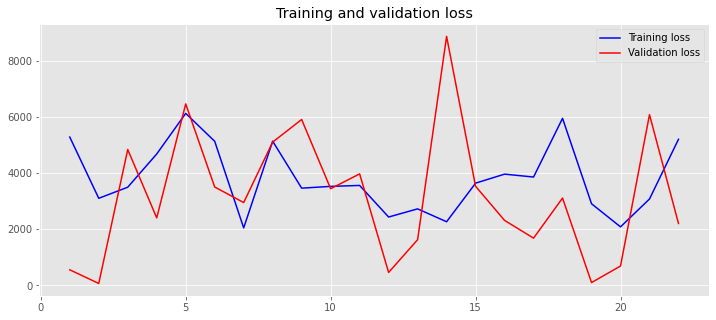

In [29]:
plt.style.use('ggplot') 
def plot_history(history): 
  loss = history.history['loss'] 
  val_loss = history.history['val_loss'] 
  x = range(1, len(loss) + 1) 


  plt.figure(figsize=(12, 5)) 
  plt.plot(x, loss, 'b', label = 'Training loss') 
  plt.plot(x, val_loss, 'r', label = 'Validation loss') 
  plt.title('Training and validation loss') 
  plt.legend() 
  plt.show() 

plot_history(hist)

**Q1: We had a argument named patiencein early stopping code. Change this number to 20 and see how number of epochs is changed. What is this patience based on your findings?**

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 20) 
callbacks_list = ModelCheckpoint('Models/Weights-{epoch:03d}--{val_loss:.5f}.hdf5', monitor = 'val_loss', save_best_only = True) 
callbacks = [early_stop, callbacks_list] 
hist = NN_model.fit(train, target, epochs = 500, batch_size = 32, validation_split = 0.2, callbacks = callbacks)

Epoch 1/500
37/37 [==============================] - 1s 11ms/step - loss: 6239.5853 - mean_absolute_error: 6239.5853 - val_loss: 7243.2378 - val_mean_absolute_error: 7243.2378
Epoch 2/500
37/37 [==============================] - 0s 5ms/step - loss: 5738.9072 - mean_absolute_error: 5738.9072 - val_loss: 3892.6738 - val_mean_absolute_error: 3892.6738
Epoch 3/500
37/37 [==============================] - 0s 5ms/step - loss: 3661.9128 - mean_absolute_error: 3661.9128 - val_loss: 1269.7894 - val_mean_absolute_error: 1269.7894
Epoch 4/500
37/37 [==============================] - 0s 4ms/step - loss: 1646.9811 - mean_absolute_error: 1646.9811 - val_loss: 679.2679 - val_mean_absolute_error: 679.2679
Epoch 5/500
37/37 [==============================] - 0s 6ms/step - loss: 2135.6813 - mean_absolute_error: 2135.6813 - val_loss: 1480.6375 - val_mean_absolute_error: 1480.6375
Epoch 6/500
37/37 [==============================] - 0s 5ms/step - loss: 1564.1697 - mean_absolute_error: 1564.1697 - val_loss

Number of epochs changed to 49.

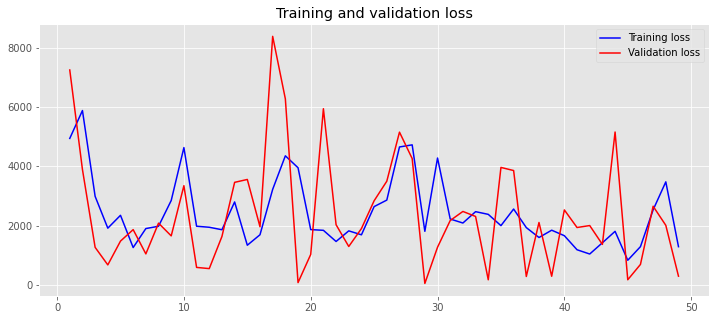

In [31]:
plot_history(hist)

**Q2: We trained a regression model but we did not analyze the performance of the model. Suggest a method to see the performance of the model. Note that since we are not dealing with categorical data, we cannot report the accuracy.**

We can analyze the performance of the model using the RMSE (Root Mean Square Error) method.

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
